In [4]:
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_op
# from WindPy import *
from functools import reduce
import datetime

## get_data

In [2]:
### 511880货基；511010债基
funds=["510330.SH","510880.SH","510900.SH","511880.SH","511010.SH","518880.SH"]
risk_funds=["510330.SH","510880.SH","510900.SH","518880.SH"]

In [5]:
data={}
for item in funds:
    name=item.split('.')[0]
    data[name]=pd.read_excel(name+'.xlsx')

In [6]:
def concat_data(columns):
    data_returns={}
    frame=[]
    for item in data.keys():
        data_returns[item]=data[item].loc[:,columns]
        data_returns[item].rename(columns={columns[1]:item,'日期':'date'},inplace=True)
        frame.append(data_returns[item])
    data1 = reduce(lambda left,right: pd.merge(left,right,on='date'), frame)
    data1.set_index('date', inplace=True)
    data1.dropna(inplace=True)
    return data1

In [7]:
### 收益率
data1=concat_data(['日期','收盘价(元)'])
rets = np.log(data1 / data1.shift(1))
rets.dropna(inplace=True)

In [8]:
n_risk=pd.read_excel('n_risk.xlsx',names=['date','interest'])
n_risk['interest']=n_risk['interest']/100
n_risk.dropna(inplace=True)
n_risk.set_index('date', inplace=True)

In [9]:
data_open=concat_data(['日期','开盘价(元)'])
data_close=concat_data(['日期','收盘价(元)'])

### 画出收益曲线

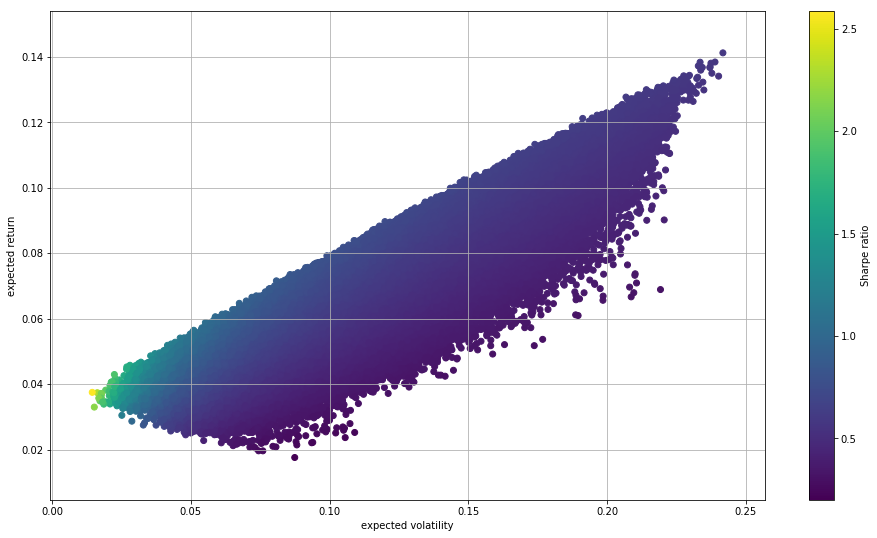

In [30]:
tmp_return = []
tmp_volatility = []

for p in range(900000):
    
    weights = np.random.random(6)
    weights /= np.sum(weights)
    expected_return = np.dot(weights.T, rets.mean())*252
    covariance_matrix = rets.cov()
    expected_volatility =np.sqrt(np.dot(np.dot(weights.T, covariance_matrix), weights)*252)
    
    tmp_return.append(expected_return)
    tmp_volatility.append(expected_volatility)

    
tmp_return = np.array(tmp_return)
tmp_volatility = np.array(tmp_volatility)

plt.figure(figsize=(16,9))
plt.scatter(tmp_volatility, tmp_return, c=tmp_return/tmp_volatility, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

### 最小方差

In [ ]:
# 最小波动率


def fun_volatility_min(weights):
    covariance_matrix = rets.cov()
    expected_volatility = np.dot(np.dot(weights.T, covariance_matrix), weights)*252
    return np.sqrt(expected_volatility)

constraints = {'type':'eq', 'fun':lambda x: np.sum(x)-1.}
bounds = tuple((0,1) for x in range(5))
weights = np.random.random(5)
weights /= np.sum(weights)
initial_guess = weights

opts = sci_op.minimize(fun=fun_volatility_min,
                       x0=initial_guess,
                       method='SLSQP',
                       bounds=bounds,
                       constraints=constraints)
print('最小波动率', opts['fun'])
print (opts)

### 目标收益率最大

In [ ]:
# 给定方差求目标收益率最大
target = 0.35 #波动率为0.35

def fun_volatility_min(weights):
    covariance_matrix = rets.cov()
    expected_volatility = np.dot(np.dot(weights.T, covariance_matrix), weights)*252
    return np.sqrt(expected_volatility)

def fun_return_max(weights):
    expected_return = np.dot(weights.T, rets.mean())*252
    return -expected_return

constraints = ({'type':'eq', 'fun':lambda x: np.sum(x)-1.},
               {'type':'eq', 'fun':lambda x: fun_volatility_min(x)-target})

bounds = tuple((0,1) for x in range(5))
weights = np.random.random(5)
weights /= np.sum(weights)
initial_guess = weights

opts = sci_op.minimize(fun=fun_return_max,
                       x0=initial_guess,
                       method='SLSQP',
                       bounds=bounds,
                       constraints=constraints)
print('波动率上限为:',target,'最大预期收益率为' ,-1*opts['fun'])
print (opts)

### 夏普比最高

In [21]:

def fun_volatility_min(weights):
    covariance_matrix = rets.cov()
    expected_volatility = np.dot(np.dot(weights.T, covariance_matrix), weights)*252
    return np.sqrt(expected_volatility)

def fun_sharp_max(weights,date):
    expected_return = np.dot(weights.T, rets.mean())*252
    expected_volatility=fun_volatility_min(weights)
    sharp=(expected_return-n_risk.loc[date,'interest'])/expected_volatility
    return -sharp


constraints = ({'type':'eq', 'fun':lambda x: np.sum(x)-1.},)

bounds = tuple((0,1) for x in range(6))
weights = np.random.random(6)
weights /= np.sum(weights)
initial_guess = weights
opts = sci_op.minimize(fun=fun_sharp_max,
                       x0=initial_guess,
                       method='SLSQP',
                       bounds=bounds,
                       constraints=constraints)
print('最大预期收益率为' ,np.dot(opts['x'].T,rets.mean())*252)
print (opts)

波动率上限为: 最大预期收益率为 0.5768859311214144
     fun: -0.5768859311214144
     jac: array([-3.95690765, -4.32605162, -0.28601333, -4.32755157, -3.47993352,
        0.01662832])
 message: 'Optimization terminated successfully.'
    nfev: 126
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([0.00000000e+00, 2.51579253e-02, 0.00000000e+00, 9.74842075e-01,
       2.80873542e-15, 0.00000000e+00])


In [24]:
np.dot(opts['x'].T,rets.mean())*252

0.03966572906212391

In [25]:
n_risk.loc['2013-07-30','interest']

0.035

In [29]:
n_risk.head()

,interest
date,
2013-04-28,0.027842
2013-05-02,0.027768
2013-05-03,0.027759
2013-05-06,0.028008
2013-05-07,0.028052


## 回测

### 定义函数

In [10]:
def max_drawdown(timeseries):
    # 回撤结束时间点
    i = np.argmax(np.maximum.accumulate(timeseries) - timeseries)
    # 回撤开始的时间点
    j = np.argmax(timeseries[:i])
    return (float(timeseries[i]) / timeseries[j]) - 1.

In [47]:
def single_sharp_value():
    single_sharps=np.zeros(4)
    for i in range(len(risk_funds)):
        item=funds[i].split('.')[0]
        single_data = tmp.loc[history_day:day,item]
        single_return = np.sum(single_data.mean())*252
        single_volatility = np.std(single_data)
        single_sharp= (single_return-n_risk.loc[day,'interest'])/single_volatility
        single_sharps[i]=single_sharp
    return single_sharps

In [18]:
def fun_volatility_min(weights):
    covariance_matrix = tmp_rets.cov()
    expected_volatility = np.dot(np.dot(weights.T, covariance_matrix), weights)*252
    return np.sqrt(expected_volatility)

def fun_sharp_max(weights):
    expected_return = np.dot(weights.T, tmp_rets.mean())*252
    expected_volatility=fun_volatility_min(weights)
    sharp=(expected_return-n_risk.loc[day,'interest'])/expected_volatility
    return -sharp


def fun_utility_max(weights):
    expected_return = np.dot(weights.T, tmp_rets.mean())*252
    expected_volatility=fun_volatility_min(weights)
    utility=expected_return-riskaverse*expected_volatility
    return -utility


In [63]:
def get_weights():
    constraints = ({'type':'eq', 'fun':lambda x: np.sum(x)-1.},)
    bounds = tuple((0,1) for x in range(4))
    weights = np.random.random(4)
    weights /= np.sum(weights)
    initial_guess = weights
    opts = sci_op.minimize(fun=fun_utility_max,
                           x0=initial_guess,
                           method='SLSQP',
                           bounds=bounds,
                           constraints=constraints)
    return opts['x']

def get_weights_tradition():
    constraints = ({'type':'eq', 'fun':lambda x: np.sum(x)-1.},)
    bounds = tuple((0,1) for x in range(6))
    weights = np.random.random(6)
    weights /= np.sum(weights)
    initial_guess = weights
    opts = sci_op.minimize(fun=fun_utility_max,
                           x0=initial_guess,
                           method='SLSQP',
                           bounds=bounds,
                           constraints=constraints)
    return opts['x']

In [64]:
date_list=rets.index.tolist()
# real_weights={}
cost=0.0003
real_weights=[]
real_rets=[]
real_change=[]
real_drawdown=[]

for i in range(591,len(date_list)):
    day=date_list[i]
    history_day=date_list[i-60]
    yesterday=date_list[i-1]
    riskaverse=0.5
#     yesterday=date_list[i-1]
#     yesterday1=datetime.datetime.strftime(date_list[i-1],'%Y-%m-%d')  
    tmp=rets.loc[history_day:yesterday,:]
    test_risk=single_sharp_value()
    j=i-591
    if i>591:
        try:
            if (test_risk<0).sum()<4:
                tmp_rets=rets.loc[history_day:yesterday,["510330","510880","510900","518880"]]
                try:
                    result=get_weights()
                    result=np.array([result[0],result[1],result[2],0,0,result[3]])
                except Exception:
                    result=real_weights[j-1]
            
                dist = np.linalg.norm(result - real_weights[j-1])

                if dist<0.15:
                    real_weights.append(real_weights[j-1])
                    rets_change=float(np.sum(real_weights[j]*rets.loc[day,:]))
                    real_rets.append(rets_change)
                    real_change.append(0)

                else:
                    real_weights.append(result)
                    change_weight=float(np.sum(abs(real_weights[j]-real_weights[j-1])))
                    rets_change1=float(change_weight*(1-cost)+1-change_weight)
                    rets_change2=float(np.sum(real_weights[j]*rets.loc[day,:]))
                    real_rets.append(float(rets_change1*rets_change2+rets_change1-1))
                    real_change.append(1)

            else:
                result=np.array([0,0,0,1,0,0])      
                real_weights.append(result)
                change_weight=float(np.sum(abs(real_weights[j]-real_weights[j-1])))
                rets_change1=float(change_weight*(1-cost)+1-change_weight)
                rets_change2=float(np.sum(real_weights[j]*rets.loc[day,:]))
                real_rets.append(float(rets_change1*rets_change2+rets_change1-1))
                real_change.append(1)


#             print(i,result)
        except Exception:
            print(str(Exception))
    else:
        if (test_risk<0).sum()<4:
            tmp_rets=rets.loc[history_day:yesterday,["510330","510880","510900","518880"]]
            result=get_weights()
            result=np.array([result[0],result[1],result[2],0,0,result[3]])
        else:
            result=np.asarray([0,0,0,1,0,0])
        
        real_weights.append(result)
        change_weight=1
        rets_change1=change_weight*(1-cost)+1-change_weight
        rets_change2=np.sum(real_weights[j]*rets.loc[day,:])
        real_rets.append(rets_change1*rets_change2+rets_change1-1)
        real_change.append(1)
    

value=np.cumprod(np.array(real_rets)+1)
for index in range(len(value)):
    if index<10:
        real_drawdown.append(0)
    else:
        real_drawdown.append(max_drawdown(value[:index+1]))
results=pd.DataFrame(np.array(real_weights),index=date_list[591:],columns=funds)
results['is_change']=real_change
results=pd.merge(results,rets,left_index=True,right_index=True)
results['value']=value
results['drawdown']=real_drawdown
results.to_excel('1-U.xlsx')

In [65]:
date_list=rets.index.tolist()
# real_weights={}
cost=0.0003
real_weights=[]
real_rets=[]
real_change=[]
real_drawdown=[]

for i in range(591,len(date_list)):
    j=i-591
    day=date_list[i]
    history_day=date_list[i-60]
    yesterday=date_list[i-1]
#     yesterday1=datetime.datetime.strftime(date_list[i-1],'%Y-%m-%d')  
    tmp_rets=rets.loc[history_day:yesterday,:]

    try:
        result=np.array(get_weights_tradition())
        real_change.append(1)
    except Exception:
        print(str(Exception))
        if j==0:
            result=np.array([0.15,0.15,0.15,0.15,0.15,0.25])
            real_change.append(1)
        else:
            result=real_weights[j-1]
            real_change.append(0)
    real_weights.append(result)
    change_weight=float(np.sum(abs(real_weights[j]-real_weights[j-1])))
    rets_change1=float(change_weight*(1-cost)+1-change_weight)
    rets_change2=float(np.sum(real_weights[j]*rets.loc[day,:]))
    real_rets.append(float(rets_change1*rets_change2+rets_change1-1))


value=np.cumprod(np.array(real_rets)+1)
for index in range(len(value)):
    if index<10:
        real_drawdown.append(0)
    else:
        real_drawdown.append(max_drawdown(value[:index+1]))
results=pd.DataFrame(np.array(real_weights),index=date_list[591:],columns=funds)
results['is_change']=real_change
results=pd.merge(results,rets,left_index=True,right_index=True)
results['value']=value
results['drawdown']=real_drawdown
results.to_excel('0-U.xlsx')

In [45]:
rets.loc['2013-07-30':'2013-08-05',:]

,510330,510880,510900,511880,511010,518880
date,,,,,,
2013-07-30,0.006494,0.011324,-0.002247,0.000093,0.001161,0.007587
2013-07-31,0.001848,0.002811,0.014517,0.000268,0.001881,0.004149
2013-08-01,0.026413,0.017392,-0.003331,0.000140,0.000995,-0.005283
2013-08-02,0.000000,-0.002762,0.005546,0.000501,-0.002021,-0.024901
2013-08-05,0.013393,0.008265,0.001106,0.000012,0.000000,0.019970


In [43]:
rets

,510330,510880,510900,511880,511010,518880
date,,,,,,
2013-07-30,0.006494,0.011324,-0.002247,0.000093,0.001161,0.007587
2013-07-31,0.001848,0.002811,0.014517,0.000268,0.001881,0.004149
2013-08-01,0.026413,0.017392,-0.003331,0.000140,0.000995,-0.005283
2013-08-02,0.000000,-0.002762,0.005546,0.000501,-0.002021,-0.024901
2013-08-05,0.013393,0.008265,0.001106,0.000012,0.000000,0.019970
2013-08-06,0.005748,0.004790,-0.008879,0.000082,0.000102,-0.014940
2013-08-07,-0.005748,-0.006162,-0.017998,0.000105,-0.003472,-0.006583
2013-08-08,-0.000444,-0.003440,-0.004551,0.000023,-0.001582,0.004651
2013-08-09,0.003543,-0.001379,0.012465,0.000326,-0.000286,0.011534
